### Описание датасета
-  Регион - субъект Российской Федерации, где находится медицинское учреждение
-  Календарный_год - год
-  Период - месяц
-  gender - пол респондента
-  poselenie - ответ на вопрос "Вы постоянно проживаете в городе или в сельской местности?"
-  Населенный_пункт - название населенного пункта, где находится медицинское учреждение
-  org_type - ответ на вопрос "В каких организациях Вы обычно получаете медицинскую помощь?"
-  last_visit - ответ на вопрос "Как давно Вы в последний раз получали медицинскую помощь?"
-  time_of_register - ответ на вопрос "Насколько Вы согласны с утверждением, что сейчас Вы можете записаться к врачу в удобное для Вас время?" (1-5 баллы по 5-бальной шкале)
-  wait_time - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания медицинской услуги с момента возникновения потребности в медицинской помощи до момента ее получения?" (1-5 баллы по 5-бальной шкале)
-  near_cab - ответ на вопрос "Насколько Вы удовлетворены длительностью ожидания непосредственно перед кабинетом?" (1-5 баллы по 5-бальной шкале)
-  comfort - ответ на вопрос "Насколько комфортным было Ваше пребывание в медицинской организации (комфортность зон ожидания, комфортное перемещение внутри медицинской организации)?" (1-5 баллы по 5-бальной шкале)
-  attitude - ответ на вопрос "Насколько Вы удовлетворены отношением к Вам со стороны медицинского персонала (врачи, мед. сестры, регистраторы, санитары)?" (1-5 баллы по 5-бальной шкале)
-  explain - ответ на вопрос "Удовлетворены ли Вы тем, как врач объяснял Вам, зачем назначено то или иное лечение, лекарственный препарат, диагностическая процедура?" (1-5 баллы по 5-бальной шкале)
-  expect - ответ на вопрос "Насколько результат Вашего обращения в медицинскую организацию соответствовал Вашим ожиданиям?" (1-5 баллы по 5-бальной шкале)
-  loyalty - ответ на вопрос "Вы бы посоветовали близким друзьям или родственникам обращаться за медицинской помощью в Вашу медицинскую организацию?" (1-5 баллы по 5-бальной шкале)
-  gen_sat - ответ на вопрос "Оцените, насколько в целом Вы удовлетворены медицинской помощью?" (1-5 баллы по 5-бальной шкале)
-  open_question_1 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в медицинской организации, в которой Вы получаете медицинскую помощь?"
-  open_question_2 - ответ на вопрос "Что Вы можете назвать наибольшей проблемой в процессе получения медицинской помощи в регионе, в котором Вы проживаете?"
-  date_of_survey - дата опроса
-  respondent_number - номер респондента
-  doctor_domestic_visit_problem - ответ на вопрос "Возникали ли у Вас сложности при вызове врача на дом?"
-  diag_services_available - ответ на вопрос "Можете ли Вы получить при оказании первичной медико-санитарной помощи в Вашей медицинской организации диагностические и лабораторные услуги?"
-  disabled_facilitites_available - ответ на вопрос "Есть ли в Вашей медицинской организации приспособления для лиц с ограниченными возможностями?
-  problem_solved - ответ на вопрос "Была ли решена Ваша медицинская проблема?"
- region_medical_care - ответ на вопрос "Оцените, насколько Вы удовлетворены доступностью медицинской помощи в Вашем регионе?"

In [85]:
import sys
print(sys.executable)

c:\Users\User\AppData\Local\Programs\Python\Python312\python.exe


In [86]:
!pip install imbalanced-learn --force-reinstall

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scipy-1.15.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl (12.6 MB)
Using cached scipy-1.15.3-cp312-cp312-win_amd64.whl (41.0 MB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl (11.1 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Atte


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
import os
from scipy.special import softmax
from scipy.stats import chi2_contingency
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [88]:
import sys
print(sys.executable)

c:\Users\User\AppData\Local\Programs\Python\Python312\python.exe


In [89]:
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [90]:
from tqdm import tqdm
tqdm.pandas()

In [91]:
df = pd.read_csv('Anketa.csv', on_bad_lines='warn', sep=';')
df.shape

C:\Users\User\AppData\Local\Temp\ipykernel_28276\3837633047.py:1: DtypeWarning: Columns (28,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Anketa.csv', on_bad_lines='warn', sep=';')


(1301055, 35)

In [92]:
df.head()


,Регион,Календарный_год,Период,gender,poselenie,Населенный_пункт,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,respondent_number,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care,age,problem_solved,Удовлетворенность_доступностью_лекарств,health_selfestimation,children_number,1st_child_health,2nd_child_health,3d_child_health,4th_child_health,5th_child_health
1311,Ленинградская область,2022,Август,Мужской,Село,"Ленинградская обл., Всеволожский р-н., г. Сертолово",Только в государственных,менее 1 мес. назад\t,5,4,4,4,3,4,4,3,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,1.000,Не пользовался данной услугой,Затрудняюсь ответить,Затрудняюсь ответить,4,19.000,Затрудняюсь ответить,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1312,Ленинградская область,2022,Август,Мужской,Город,"Ленинградская обл., Всеволожский р-н., г. Всеволожск",Только в частных,более 12 мес. назад,Затрудняюсь ответить,5,Затрудняюсь ответить,5,Затрудняюсь ответить,Затрудняюсь ответить,Затрудняюсь ответить,5,Затрудняюсь ответить,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,2.000,Нет,Затрудняюсь ответить,Да,5,22.000,Да,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1313,Ленинградская область,2022,Август,Мужской,Город,"Ленинградская обл., Гатчинский р-н., г. Гатчина",Только в государственных,менее 1 мес. назад\t,3,2,5,5,5,Затрудняюсь ответить,5,4,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,3.000,Нет,Затрудняюсь ответить,Да,5,28.000,Да,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1314,Ленинградская область,2022,Август,Мужской,Село,"Ленинградская обл., Волосовский р-н., Торосово д.",Только в государственных,более 12 мес. назад,5,4,5,5,5,5,Затрудняюсь ответить,5,5,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,4.000,Да,Да,Да,Затрудняюсь ответить,30.000,Да,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1315,Ленинградская область,2022,Август,Мужской,Город,"Ленинградская обл., Выборгский р-н., г. Выборг",Только в государственных,менее 1 мес. назад\t,Затрудняюсь ответить,5,5,5,Затрудняюсь ответить,Затрудняюсь ответить,Затрудняюсь ответить,5,Затрудняюсь ответить,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,5.000,Нет,Затрудняюсь ответить,Да,Затрудняюсь ответить,34.000,Да,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# Переименуем колонки
column_mapping = {
    'Календарный_год': 'year',
    'Регион': 'Region',
    'Период': 'period',
    'poselenie': 'locality_type',
    'Населенный_пункт': 'locality',
    'zapis': 'time_of_register',
    'ozhid': 'wait_time',
    'Дата_проведения_опроса_в_формате_дд_мм_гггг': 'date_of_survey',
    'Номер_респондента': 'respondent_number',
    '16': 'region_medical_care_availability',
    '17': 'doctor_domestic_visit_problem',
    '18': 'diag_services_available',
    '19': 'disabled_facilitites_available',
    'Возраст': 'Age'
}

df = df.rename(columns=column_mapping)
columns_to_remove = ['Id', 'Удовлетворенность_доступностью_лекарств', 'health_selfestimation', 'children_number', '1st_child_health', '2nd_child_health', '3d_child_health', '4th_child_health', '5th_child_health']
df = df.drop(columns=columns_to_remove, errors='ignore')
df.head()

,Region,year,period,gender,locality_type,locality,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,respondent_number,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care,age,problem_solved
1311,Ленинградская область,2022,Август,Мужской,Село,"Ленинградская обл., Всеволожский р-н., г. Сертолово",Только в государственных,менее 1 мес. назад\t,5,4,4,4,3,4,4,3,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,1.000,Не пользовался данной услугой,Затрудняюсь ответить,Затрудняюсь ответить,4,19.000,Затрудняюсь ответить
1312,Ленинградская область,2022,Август,Мужской,Город,"Ленинградская обл., Всеволожский р-н., г. Всеволожск",Только в частных,более 12 мес. назад,Затрудняюсь ответить,5,Затрудняюсь ответить,5,Затрудняюсь ответить,Затрудняюсь ответить,Затрудняюсь ответить,5,Затрудняюсь ответить,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,2.000,Нет,Затрудняюсь ответить,Да,5,22.000,Да
1313,Ленинградская область,2022,Август,Мужской,Город,"Ленинградская обл., Гатчинский р-н., г. Гатчина",Только в государственных,менее 1 мес. назад\t,3,2,5,5,5,Затрудняюсь ответить,5,4,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,3.000,Нет,Затрудняюсь ответить,Да,5,28.000,Да
1314,Ленинградская область,2022,Август,Мужской,Село,"Ленинградская обл., Волосовский р-н., Торосово д.",Только в государственных,более 12 мес. назад,5,4,5,5,5,5,Затрудняюсь ответить,5,5,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,4.000,Да,Да,Да,Затрудняюсь ответить,30.000,Да
1315,Ленинградская область,2022,Август,Мужской,Город,"Ленинградская обл., Выборгский р-н., г. Выборг",Только в государственных,менее 1 мес. назад\t,Затрудняюсь ответить,5,5,5,Затрудняюсь ответить,Затрудняюсь ответить,Затрудняюсь ответить,5,Затрудняюсь ответить,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,5.000,Нет,Затрудняюсь ответить,Да,Затрудняюсь ответить,34.000,Да


#### EDA

##### Разберемся, что делать с вариантами Затрудняюсь ответить

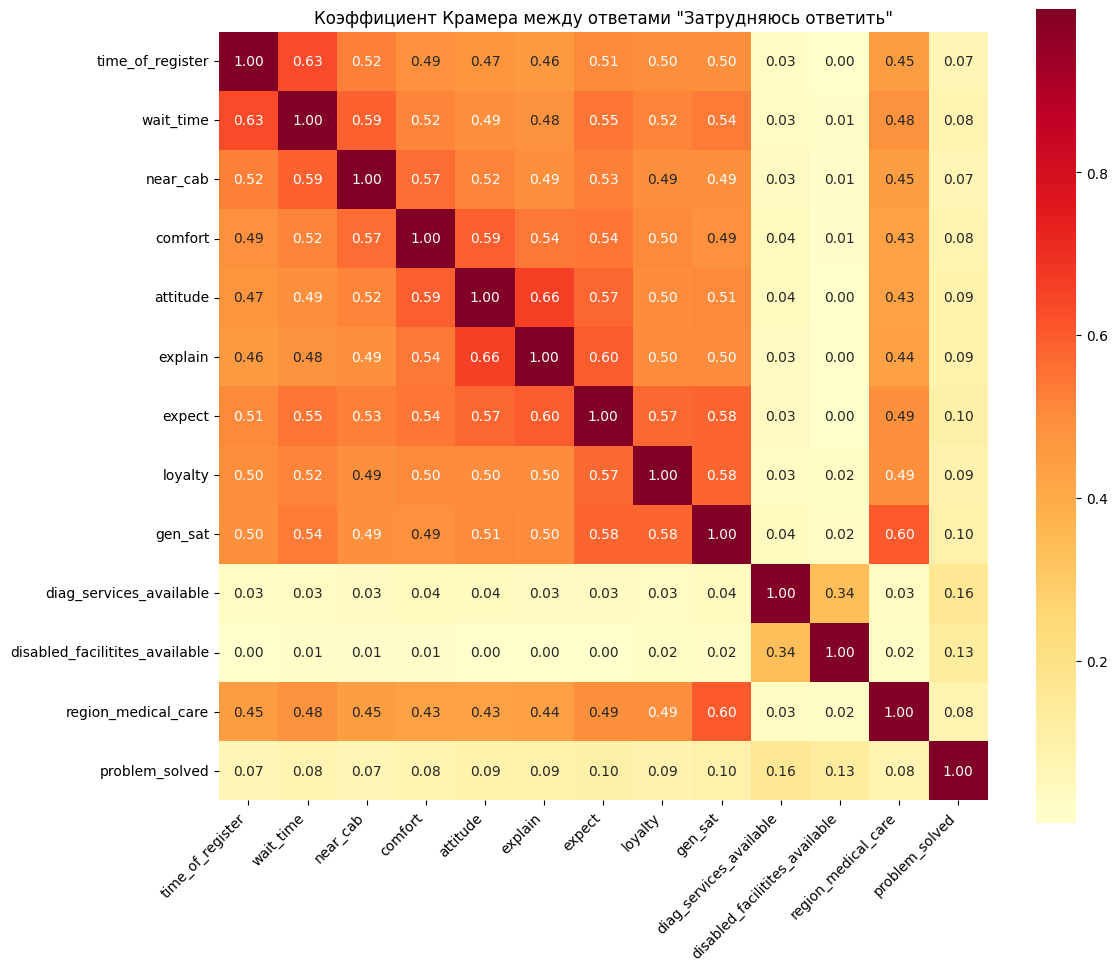

In [94]:
# Список колонок для анализа
columns = [
    'time_of_register', 'wait_time', 'near_cab', 'comfort',
    'attitude', 'explain', 'expect', 'loyalty', 'gen_sat',
    'diag_services_available', 'disabled_facilitites_available',
    'region_medical_care', 'problem_solved'
]

# Создаем матрицы для хранения результатов
association_matrix = pd.DataFrame(index=columns, columns=columns)
cramer_matrix = pd.DataFrame(index=columns, columns=columns)

# Функция для вычисления коэффициента Крамера
def cramers_v(contingency_matrix):
    try:
        chi2 = chi2_contingency(contingency_matrix)[0]
        n = contingency_matrix.sum().sum()
        min_dim = min(contingency_matrix.shape) - 1
        return np.sqrt(chi2 / (n * min_dim)) if n * min_dim > 0 else 0.0
    except:
        return 0.0

# Заполняем матрицы
for col1 in columns:
    for col2 in columns:
        # Создаем таблицу сопряженности для "Затрудняюсь ответить"
        mask1 = df[col1] == 'Затрудняюсь ответить'
        mask2 = df[col2] == 'Затрудняюсь ответить'
        contingency = pd.crosstab(mask1, mask2)
        
        # Вычисляем коэффициент Крамера
        cramer_v = cramers_v(contingency)
        cramer_matrix.loc[col1, col2] = cramer_v        


# Создаем тепловую карту для коэффициента Крамера
plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix.astype(float), 
            annot=True, 
            cmap='YlOrRd', 
            fmt='.2f',
            square=True)
plt.title('Коэффициент Крамера между ответами "Затрудняюсь ответить"')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Видно, что problem_solved не зависит от других ответов

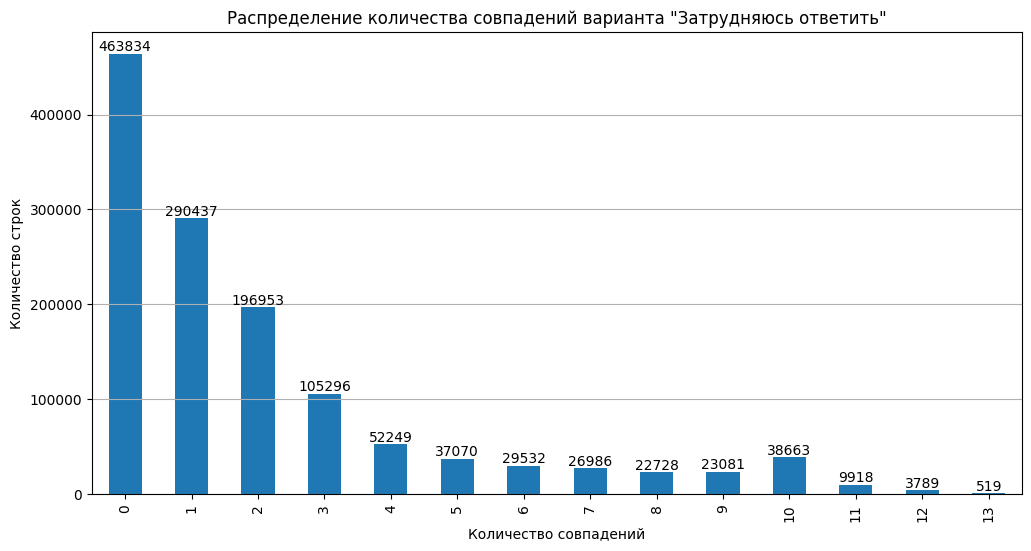

In [95]:
# Предположим, что строки с вариантом "Затрудняюсь ответить" можно удалить

# Создаем маску для каждого столбца
masks = {col: df[col] == 'Затрудняюсь ответить' for col in columns}

# Создаем DataFrame с масками
mask_df = pd.DataFrame(masks)

# Подсчитываем количество совпадений для каждой строки
mask_df['count'] = mask_df.sum(axis=1)

# Группируем по количеству совпадений и подсчитываем частоту
coincidence_counts = mask_df['count'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
ax = coincidence_counts.plot(kind='bar')
plt.title('Распределение количества совпадений варианта "Затрудняюсь ответить"')
plt.xlabel('Количество совпадений')
plt.ylabel('Количество строк')
plt.grid(True, axis='y')
for i, v in enumerate(coincidence_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')
plt.show()
# TODO добавить +1

In [96]:
# Удаляем строки, где количество совпадений варианта "Затрудняюсь ответить" равно 10 или 11
rows_to_drop = mask_df[mask_df['count'].isin([10, 11, 12, 13])].index
df = df.drop(rows_to_drop)
print(df.shape)

(1248166, 27)


##### Сгенерим новые фичи на основе вариантов Затрудняюсь ответить на этапе генерации фич


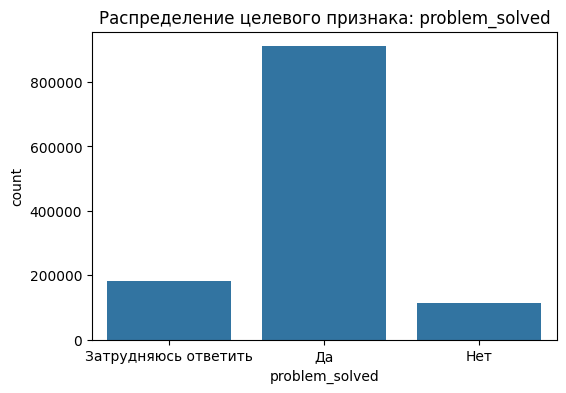

In [97]:
# Целевой признак: problem_solved
plt.figure(figsize=(6, 4))
sns.countplot(x='problem_solved', data=df)
plt.title('Распределение целевого признака: problem_solved')
plt.show()
# TODO сделать 3 класса

In [98]:

# Закодируем этот таргет one hot encoding на этапе генерации фич, а имбаланс исправим на этапе разделдения выборок
# SMOTE, sklearn imbalanced

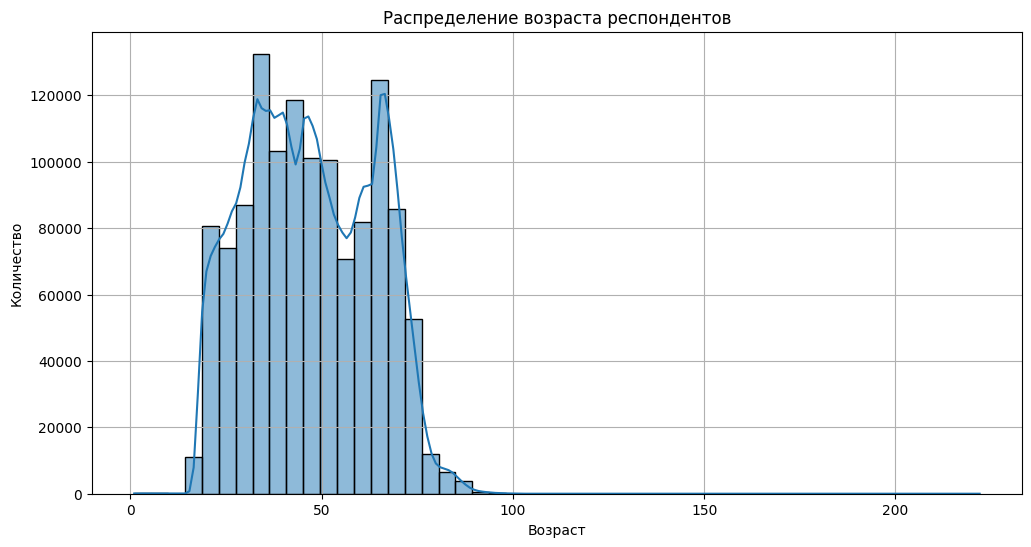


Статистика по возрасту:
count   1248162.000
mean         47.105
std          16.320
min           1.000
25%          34.000
50%          46.000
75%          61.000
max         222.000
Name: age, dtype: float64


In [99]:
# Целевой признак: Age
# Строим распределение возраста
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='age', bins=50, kde=True)
plt.title('Распределение возраста респондентов')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

# Выводим базовую статистику
print("\nСтатистика по возрасту:")
print(df['age'].describe())


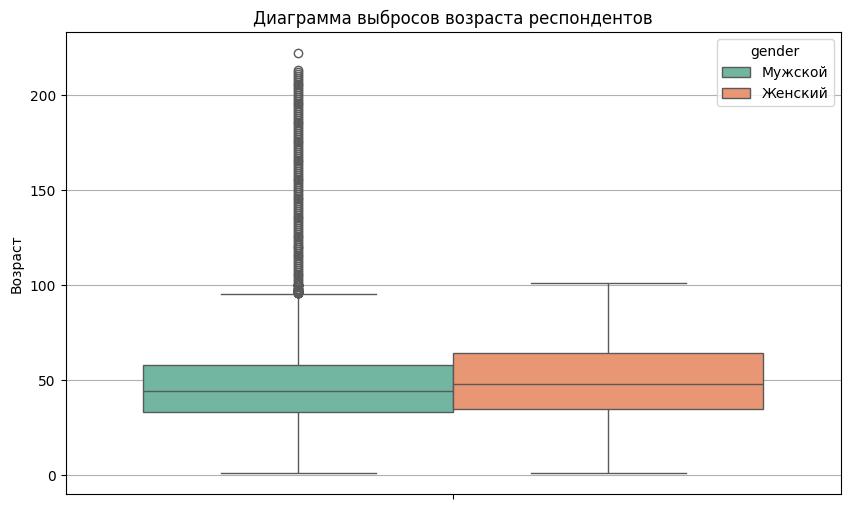

In [100]:
# Удалим строки с возрастом меньше 18 и аномальными значениями сверху
# Создаем box plot для анализа выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='age', hue='gender', palette='Set2')
plt.title('Диаграмма выбросов возраста респондентов')
plt.ylabel('Возраст')
plt.grid(True, axis='y')

In [101]:
# TODO подумать над аномалией выбросов возраста
# TODO сначала удалить невозможные данные

In [102]:
# Расчёт квартилей и IQR
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

In [103]:
# Верхняя граница
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов сверху
df = df[df['age'] <= upper_bound]
# Удалим строки с возрастом меньше 18
df = df[df['age'] >= 18]

In [104]:
df.shape

(1247745, 27)

In [105]:
# Пропуски
display(df.isnull().sum())

Region                                 0
year                                   0
period                                 0
gender                                 1
locality_type                          1
locality                             695
org_type                           39454
last_visit                         39776
time_of_register                   39429
wait_time                          39421
near_cab                           39426
comfort                            39424
attitude                           39431
explain                            39431
expect                             39488
loyalty                            39530
gen_sat                               19
open_question_1                   210738
open_question_2                   247681
date_of_survey                         3
respondent_number                   1552
doctor_domestic_visit_problem      82189
diag_services_available            92287
disabled_facilitites_available     93995
region_medical_c

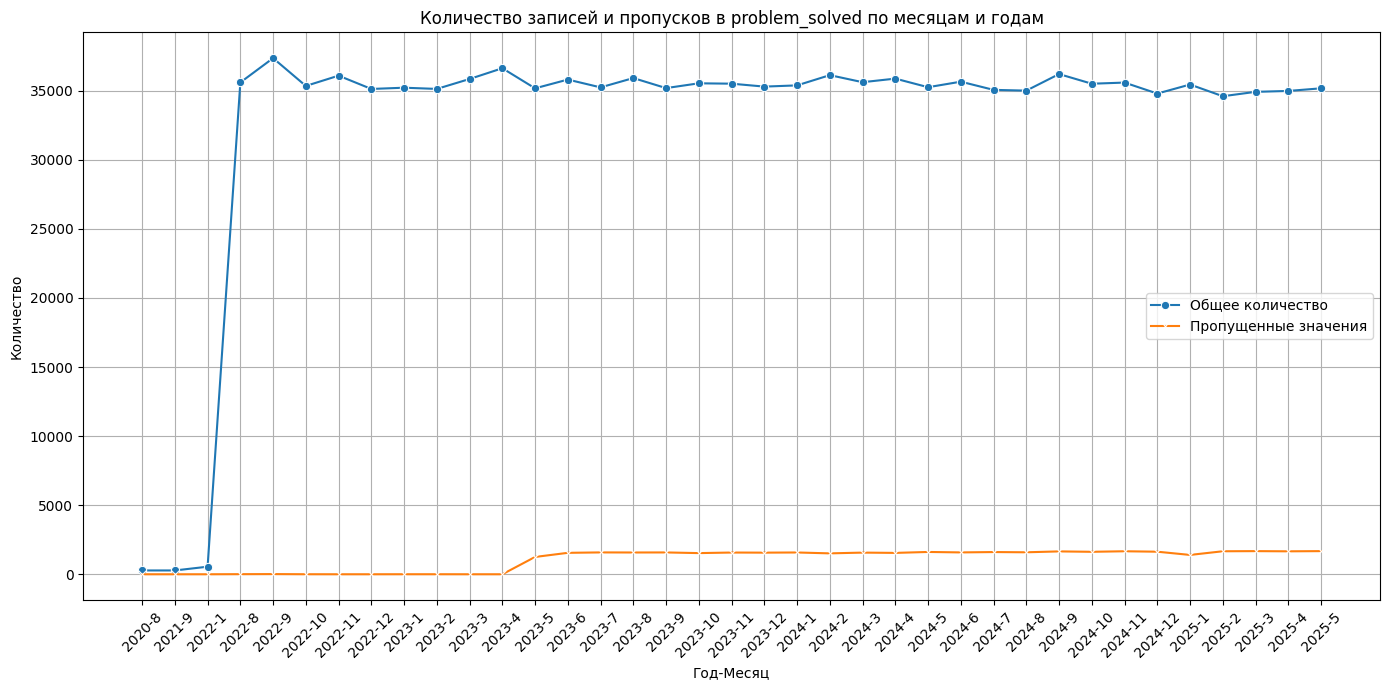

In [106]:
# Посмотрим пропуски в target
period_mapping = {
    'Январь': 1,
    'Февраль': 2,
    'Март': 3,
    'Апрель': 4,
    'Май': 5,
    'Июнь': 6,
    'Июль': 7,
    'Август': 8,
    'Сентябрь': 9,
    'Октябрь': 10,
    'Ноябрь': 11,
    'Декабрь': 12
}

# Применяем маппинг к столбцу 'period'
df['period'] = df['period'].map(period_mapping)

# Группируем данные
grouped_total = df.groupby(['year', 'period'])['problem_solved'].count().rename('total_count')
grouped_missing = df.groupby(['year', 'period'])['problem_solved'].apply(lambda x: x.isnull().sum()).rename('missing_count')

result = pd.concat([grouped_total, grouped_missing], axis=1).reset_index()

result['Year_Month'] = result['year'].astype(str) + '-' + result['period'].astype(str)

# Строим график
plt.figure(figsize=(14, 7))
sns.lineplot(data=result, x='Year_Month', y='total_count', label='Общее количество', marker='o')
sns.lineplot(data=result, x='Year_Month', y='missing_count', label='Пропущенные значения', marker='x')

plt.xticks(rotation=45)
plt.title('Количество записей и пропусков в problem_solved по месяцам и годам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Удаляем ненужные колонки
# df = df.drop(columns=['respondent_number'])
# TODO посмотреть почему много пропусков
# TODO посмотреть есть ли комментарий

In [107]:
# Проверим, может дело в Регионе
# Группировка с учётом региона
grouped_total = df.groupby(['year', 'period', 'Region'])['problem_solved'].count().rename('total_count')
grouped_missing = df.groupby(['year', 'period', 'Region'])['problem_solved'].apply(lambda x: x.isnull().sum()).rename('missing_count')

# Объединение результатов
result = pd.concat([grouped_total, grouped_missing], axis=1).reset_index()
result = result.sort_values(by=['missing_count','year', 'period', 'Region'],
                            ascending=[False, True, True, True]).head(15)
display(result)


,year,period,Region,total_count,missing_count
2737,2025,3,Донецкая Народная Республика,0,648
2915,2025,5,Донецкая Народная Республика,0,646
2648,2025,2,Донецкая Народная Республика,0,643
2381,2024,11,Донецкая Народная Республика,0,642
2826,2025,4,Донецкая Народная Республика,0,638
2203,2024,9,Донецкая Народная Республика,0,635
2559,2025,1,Донецкая Народная Республика,0,618
2470,2024,12,Донецкая Народная Республика,0,614
2292,2024,10,Донецкая Народная Республика,0,603
2025,2024,7,Донецкая Народная Республика,0,592


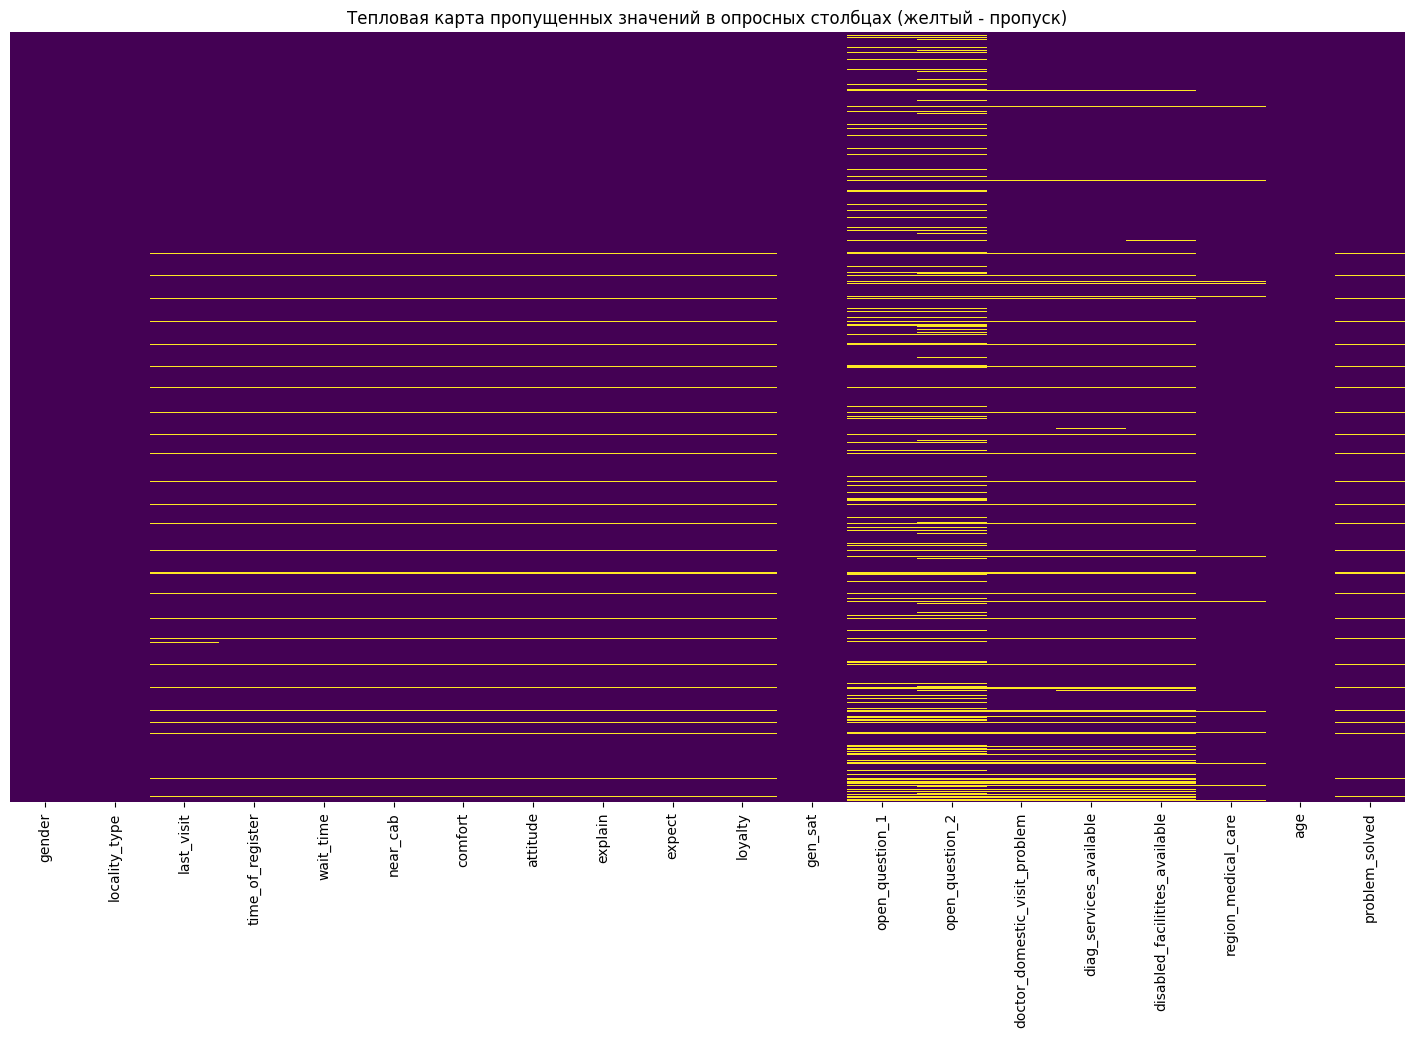

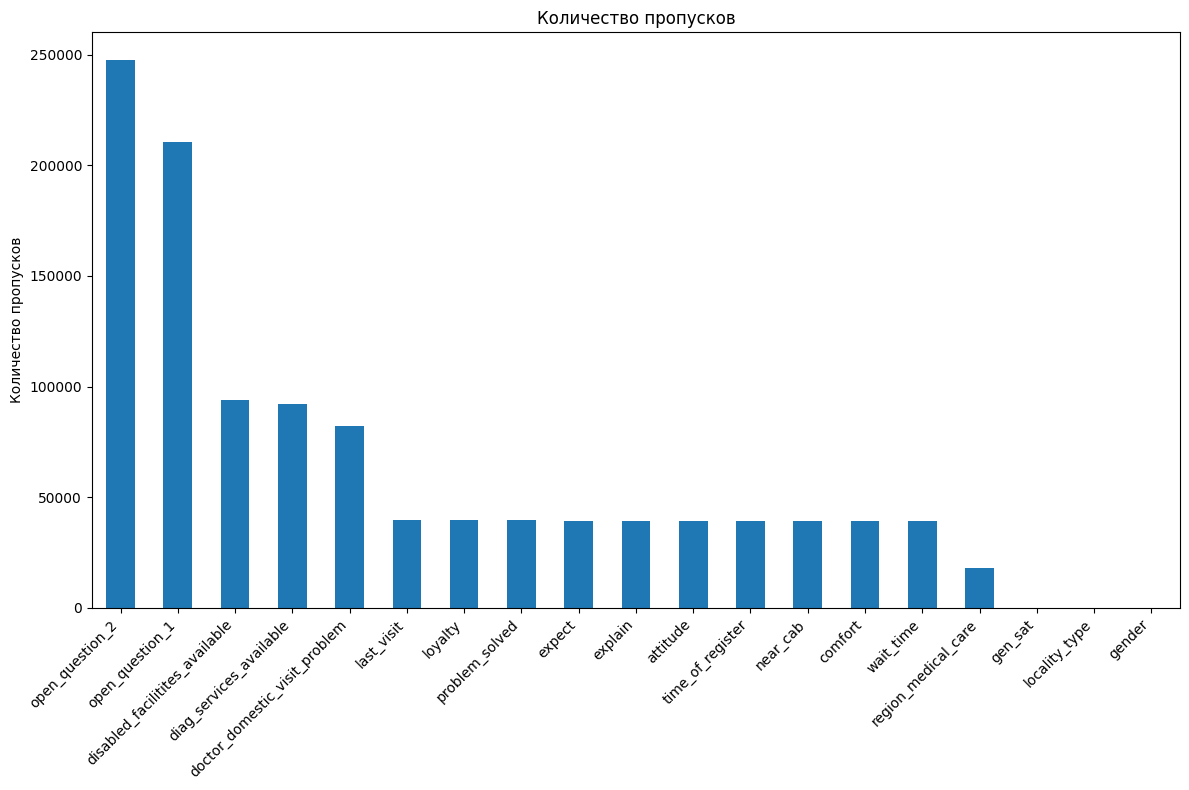

In [108]:
# Посмотрим на пропуски более детально: м.б. строки пустые целиком (т.е. мусор), 
# либо респонденты не ответили на вопросы после того, как посатвили низкую оценку по одному из вопросов (1-2)
df_analysis = df.copy()
# Столбцы, которые НЕ являются оценочными/опросными
id_cols = ['Region', 'year', 'period', 'date_of_survey', 'respondent_number', 'locality', 'org_type']
# Опросные/оценочные столбцы (все, кроме id_cols)
survey_cols = [col for col in df_analysis.columns if col not in id_cols]
# --- 2. Визуализация общего распределения пропусков ---
plt.figure(figsize=(18, 10))
sns.heatmap(df_analysis[survey_cols].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Тепловая карта пропущенных значений в опросных столбцах (желтый - пропуск)')
plt.show()

missing_counts = df_analysis[survey_cols].isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0] # Только столбцы с пропусками

plt.figure(figsize=(12, 8))
missing_counts.plot(kind='bar')
plt.title('Количество пропусков')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

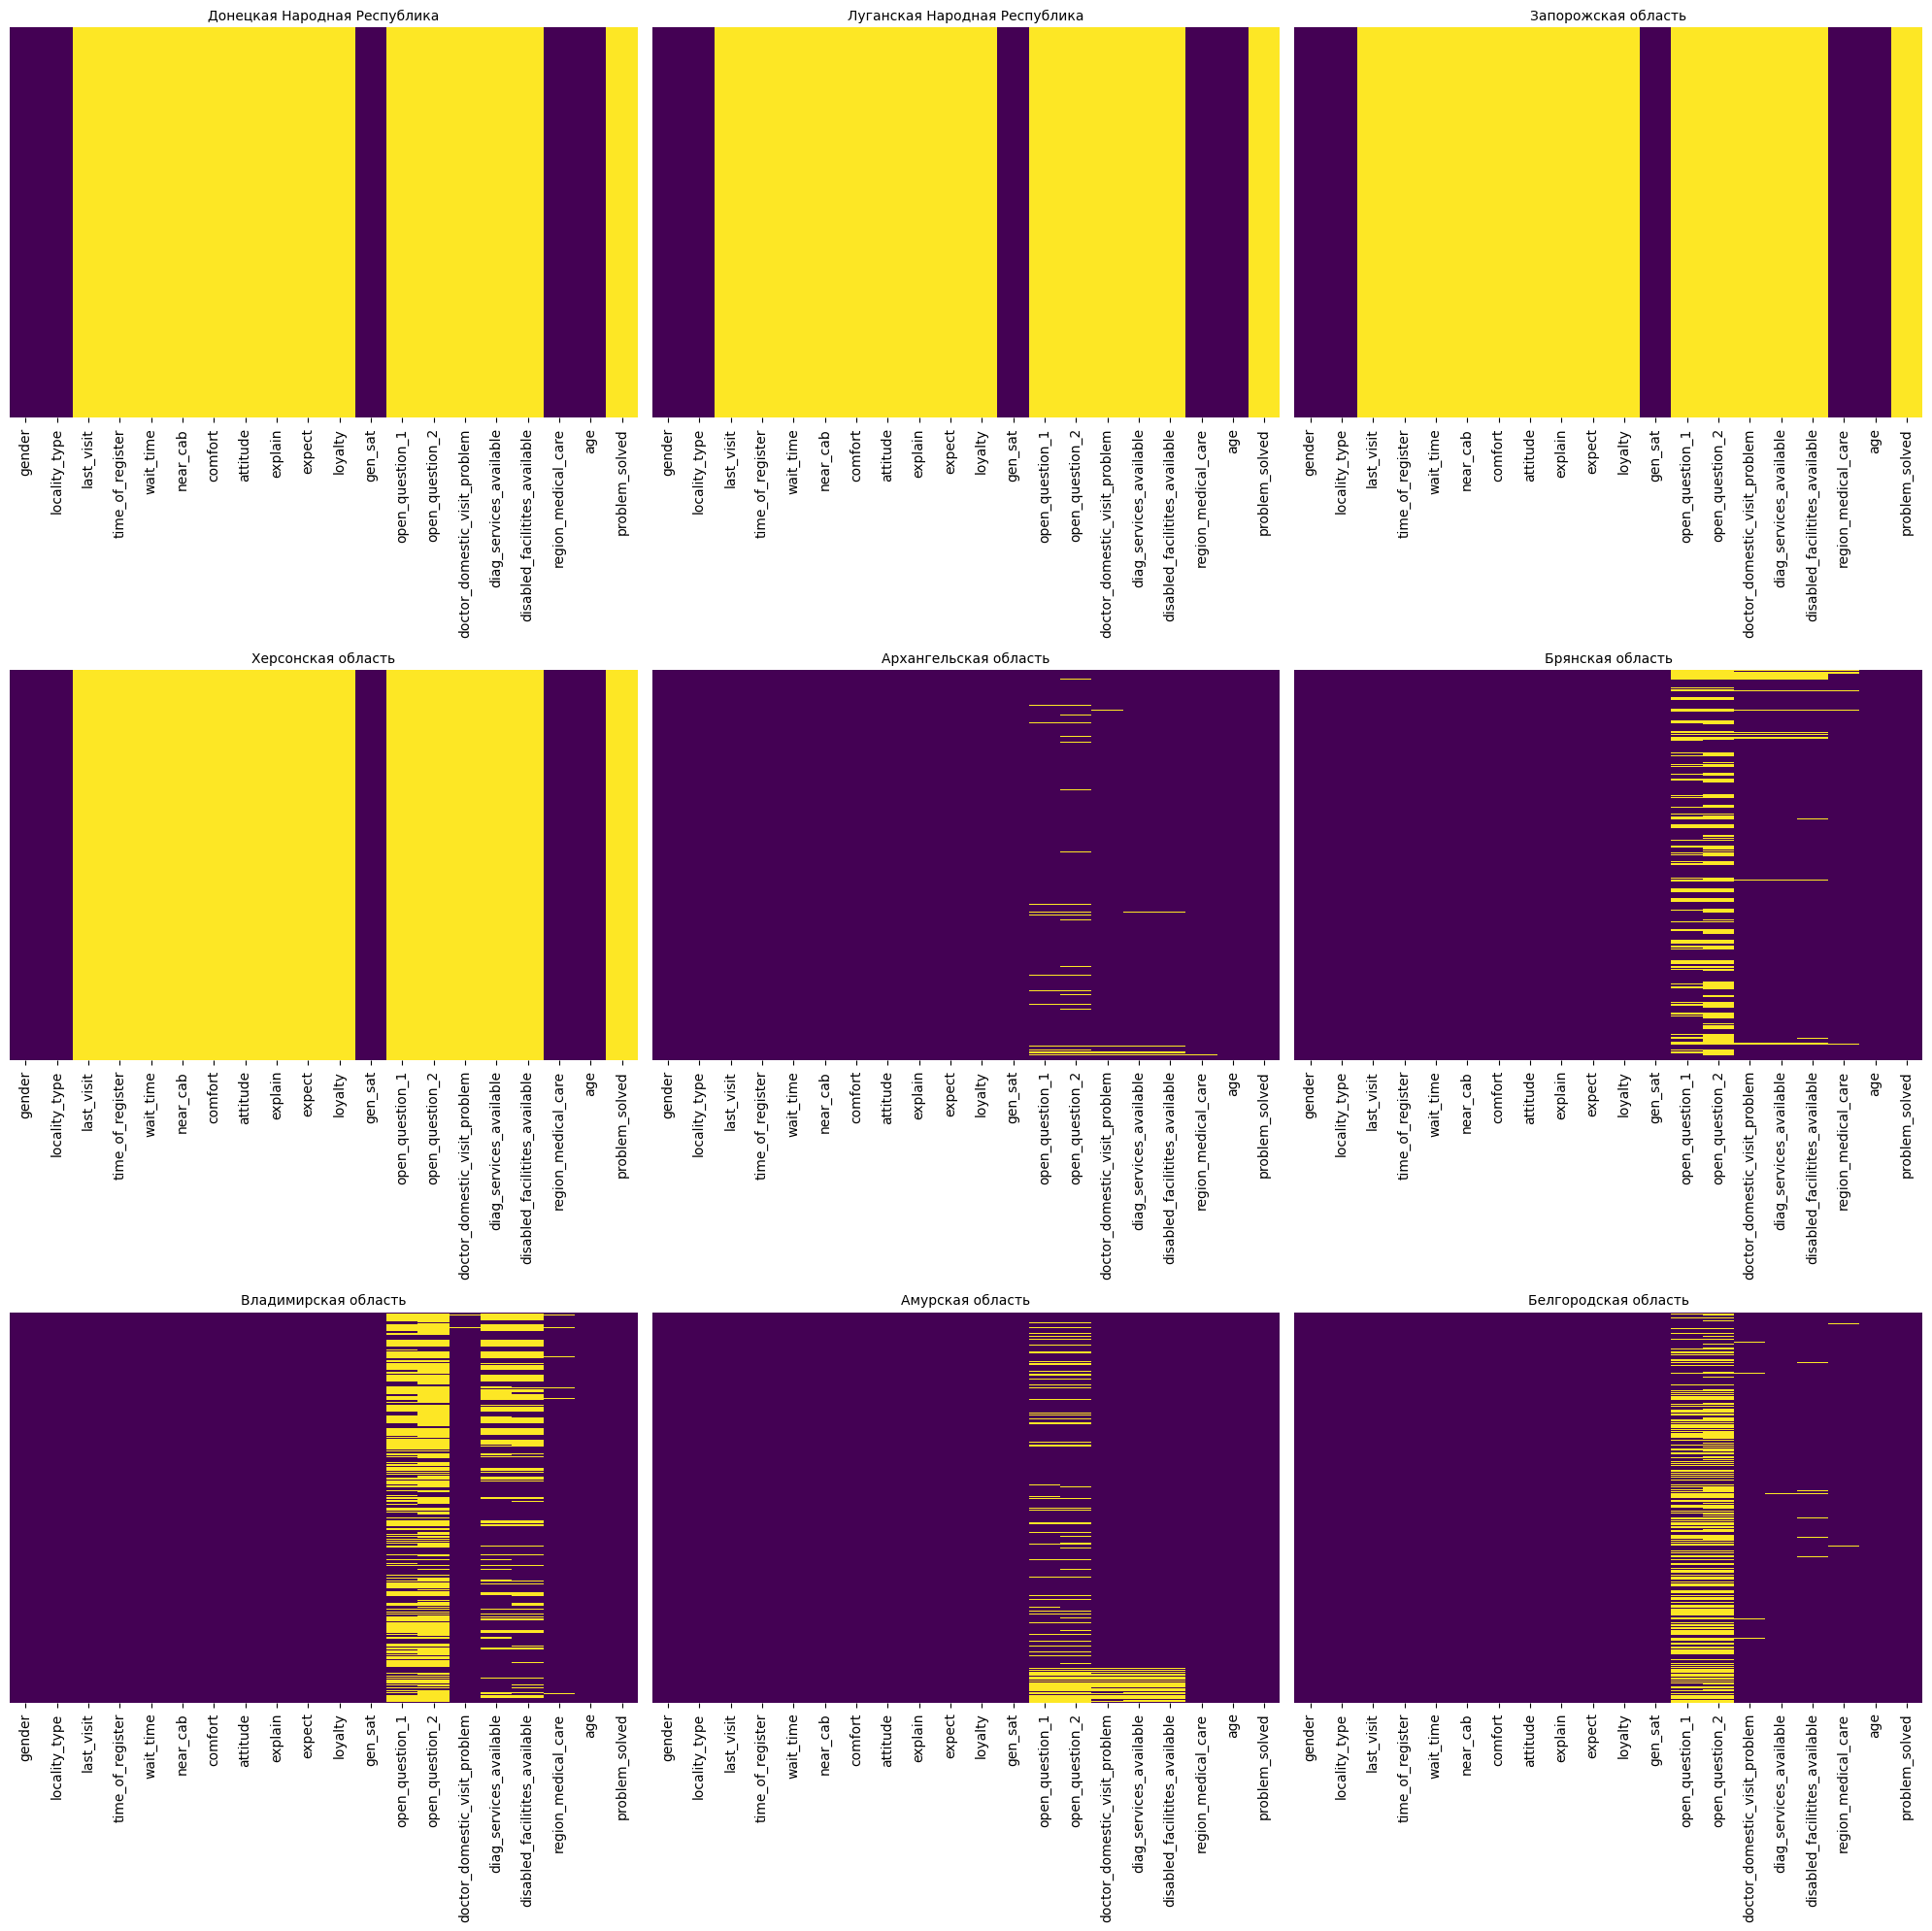

In [109]:
# Получаем топ-16 регионов по количеству пропусков
filtered_df = df[
    (df['period'] == 6) & 
    (df['year'] == 2023)
]
top_regions = filtered_df.groupby('Region')['problem_solved'].apply(lambda x: x.isna().sum()).sort_values(ascending=False).head(9).index
# Создаем фигуру с 16 subplots (4x4)
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

# heatmaps
for idx, region in enumerate(top_regions):
    region_data = df[df['Region'] == region]
    missing_matrix = region_data[survey_cols].isnull()
    sns.heatmap(missing_matrix, 
                ax=axes[idx],
                cbar=False,
                cmap='viridis',
                yticklabels=False)
    
    axes[idx].set_title(f'{region}', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

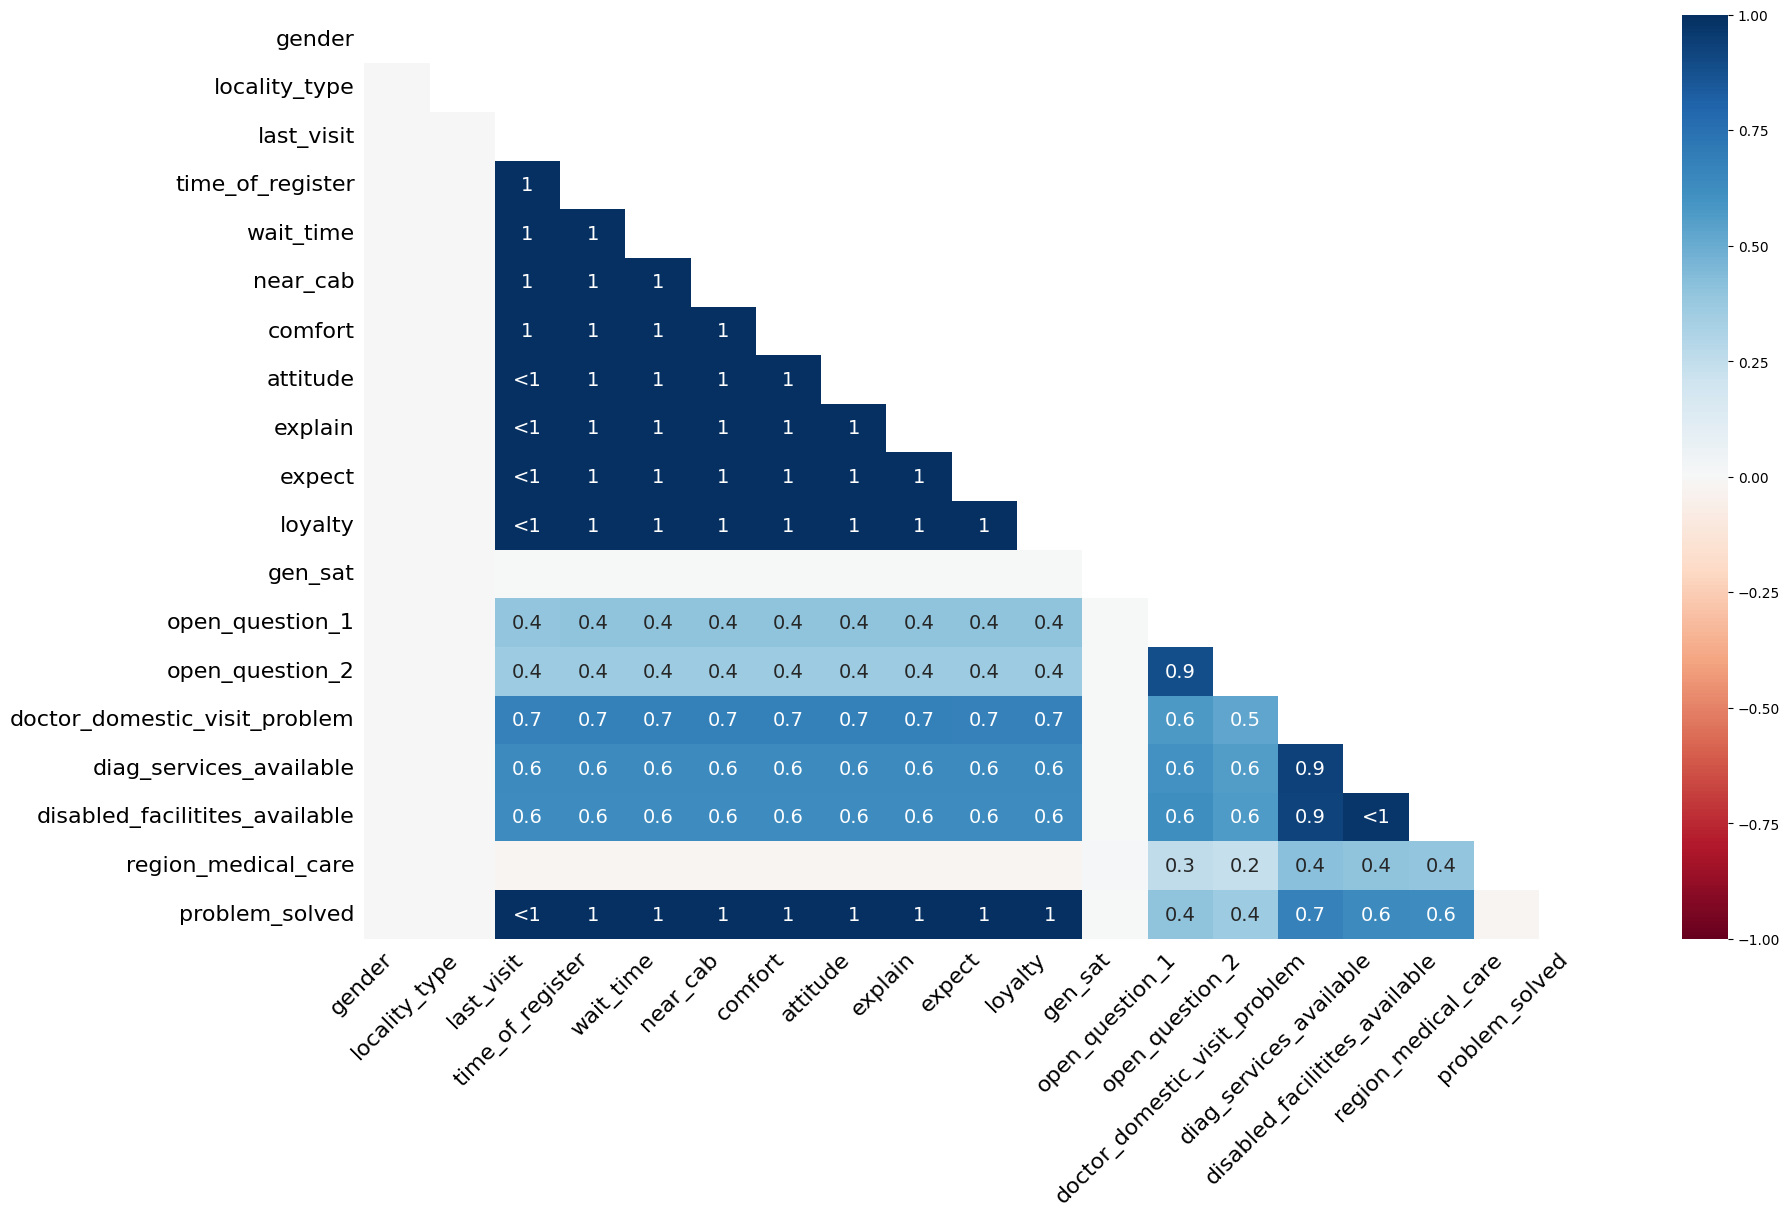

In [110]:
# можно посмтотреть, какие признаки остутствуют вместе, что свидетельствует о полностью пустых строках
import missingno as msno
msno.heatmap(df[survey_cols])
plt.show()


In [111]:
# можно удалить пустые строки
df = df.dropna(subset=['problem_solved'])
df.shape

(1208250, 27)

In [112]:
# TODO Можно также посмотреть как меняется возраст в завсисмости от региона и даты
top_10_regions = df['Region'].value_counts().head(10).index
  
pivot_data = pd.pivot_table(
    df[
        (df['Region'].isin(top_10_regions)) & 
        (df['period'].isin([1, 2, 3, 4, 5, 6])) & 
        (df['year'] == 2024)
    ],
    values='gen_sat',
    index='Region',
    columns=['period','gender'],
    aggfunc=lambda x: round(((x == '4') | (x == '5')).mean() * 100, 1)
)
display(pivot_data.style
        .background_gradient(cmap='Blues', vmin=0, vmax=100)
        .format('{:.1f}%')
        )
# TODO добавить хи квадрат для связи между полом и оценкой
# условие на расраску ячеек в таблице pivot_data

In [113]:
# TODO проверить гипотезу от разной значимости признаков для женщин и мужчин, также для разных возрастов

In [114]:
# TODO могут быть подозрительные данные, когда ту же самую анекету залили в следующем периоде

In [115]:
# TODO доделать преобразование в координаты и создание карты
# df.drop_duplicates(inplace=True)
#df_sample = df.sample(n=10).copy()

In [116]:
'''
# Инициализация геокодера
geolocator = Nominatim(user_agent="geo_example")

# Название села
# location = geolocator.geocode("село Лопатино, Россия")

geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

df_sample['geo_coordinates'] = df_sample['Населенный_пункт'].progress_apply(lambda x: (None, None) if pd.isna(x) else geocode(x))


df_sample['latitude'] = df_sample['geo_coordinates'].progress_apply(lambda loc: loc.latitude if loc else None)
df_sample['longitude'] = df_sample['geo_coordinates'].progress_apply(lambda loc: loc.longitude if loc else None)


display(df_sample.head())


missing_coordinates_count = df_sample['geo_coordinates'].isnull().sum()
print(f"\nNumber of rows with missing coordinates: {missing_coordinates_count}")
'''

'\n# Инициализация геокодера\ngeolocator = Nominatim(user_agent="geo_example")\n\n# Название села\n# location = geolocator.geocode("село Лопатино, Россия")\n\ngeocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)\n\ndf_sample[\'geo_coordinates\'] = df_sample[\'Населенный_пункт\'].progress_apply(lambda x: (None, None) if pd.isna(x) else geocode(x))\n\n\ndf_sample[\'latitude\'] = df_sample[\'geo_coordinates\'].progress_apply(lambda loc: loc.latitude if loc else None)\ndf_sample[\'longitude\'] = df_sample[\'geo_coordinates\'].progress_apply(lambda loc: loc.longitude if loc else None)\n\n\ndisplay(df_sample.head())\n\n\nmissing_coordinates_count = df_sample[\'geo_coordinates\'].isnull().sum()\nprint(f"\nNumber of rows with missing coordinates: {missing_coordinates_count}")\n'

In [117]:
# TODO обработать текст open_question_1 и open_question_2
# TODO заджойнить с другими таблицами

### Feature Engineering

In [118]:
# Перевернем таргет
df['problem_solved'] = df['problem_solved'].replace(['Да', 'Нет', 'Затрудняюсь ответить'], [1, 0, 2])
problem_solved_dummies = pd.get_dummies(df['problem_solved'], prefix='problem')
problem_solved_dummies.columns = ['problem_solved_', 'problem_not_solved', 'problem_not_answered']
df = pd.concat([df, problem_solved_dummies], axis=1)
df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_28276\3450561982.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['problem_solved'] = df['problem_solved'].replace(['Да', 'Нет', 'Затрудняюсь ответить'], [1, 0, 2])


,Region,year,period,gender,locality_type,locality,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,respondent_number,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care,age,problem_solved,problem_solved_,problem_not_solved,problem_not_answered
1311,Ленинградская область,2022,8,Мужской,Село,"Ленинградская обл., Всеволожский р-н., г. Сертолово",Только в государственных,менее 1 мес. назад\t,5,4,4,4,3,4,4,3,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,1.000,Не пользовался данной услугой,Затрудняюсь ответить,Затрудняюсь ответить,4,19.000,2,False,False,True
1312,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Всеволожский р-н., г. Всеволожск",Только в частных,более 12 мес. назад,Затрудняюсь ответить,5,Затрудняюсь ответить,5,Затрудняюсь ответить,Затрудняюсь ответить,Затрудняюсь ответить,5,Затрудняюсь ответить,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,2.000,Нет,Затрудняюсь ответить,Да,5,22.000,1,False,True,False
1313,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Гатчинский р-н., г. Гатчина",Только в государственных,менее 1 мес. назад\t,3,2,5,5,5,Затрудняюсь ответить,5,4,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,3.000,Нет,Затрудняюсь ответить,Да,5,28.000,1,False,True,False
1314,Ленинградская область,2022,8,Мужской,Село,"Ленинградская обл., Волосовский р-н., Торосово д.",Только в государственных,более 12 мес. назад,5,4,5,5,5,5,Затрудняюсь ответить,5,5,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,4.000,Да,Да,Да,Затрудняюсь ответить,30.000,1,False,True,False
1315,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Выборгский р-н., г. Выборг",Только в государственных,менее 1 мес. назад\t,Затрудняюсь ответить,5,5,5,Затрудняюсь ответить,Затрудняюсь ответить,Затрудняюсь ответить,5,Затрудняюсь ответить,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,5.000,Нет,Затрудняюсь ответить,Да,Затрудняюсь ответить,34.000,1,False,True,False


In [119]:
# Удаляем колонки с таргетом
df = df.drop('problem_solved', axis=1)

In [120]:


# создадим фичи на основе вариантов Затрудняюсь ответить
columns = [
    'time_of_register', 'wait_time', 'near_cab', 'comfort',
    'attitude', 'explain', 'expect', 'loyalty', 'gen_sat',
    'diag_services_available', 'disabled_facilitites_available',
    'region_medical_care'
]

for col in columns:
    df[f'{col}_difficult'] = (df[col] == 'Затрудняюсь ответить').astype(int)
    mode_value = df[col].replace('Затрудняюсь ответить', np.nan).mode()[0]
    df[col] = df[col].replace('Затрудняюсь ответить', mode_value)    

df.head()

,Region,year,period,gender,locality_type,locality,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,respondent_number,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care,age,problem_solved_,problem_not_solved,problem_not_answered,time_of_register_difficult,wait_time_difficult,near_cab_difficult,comfort_difficult,attitude_difficult,explain_difficult,expect_difficult,loyalty_difficult,gen_sat_difficult,diag_services_available_difficult,disabled_facilitites_available_difficult,region_medical_care_difficult
1311,Ленинградская область,2022,8,Мужской,Село,"Ленинградская обл., Всеволожский р-н., г. Сертолово",Только в государственных,менее 1 мес. назад\t,5,4,4,4,3,4,4,3,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,1.000,Не пользовался данной услугой,Да,Да,4,19.000,False,False,True,0,0,0,0,0,0,0,0,0,1,1,0
1312,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Всеволожский р-н., г. Всеволожск",Только в частных,более 12 мес. назад,4,5,4,5,4,4,4,5,5,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,2.000,Нет,Да,Да,5,22.000,False,True,False,1,0,1,0,1,1,1,0,1,1,0,0
1313,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Гатчинский р-н., г. Гатчина",Только в государственных,менее 1 мес. назад\t,3,2,5,5,5,4,5,4,4,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,3.000,Нет,Да,Да,5,28.000,False,True,False,0,0,0,0,0,1,0,0,0,1,0,0
1314,Ленинградская область,2022,8,Мужской,Село,"Ленинградская обл., Волосовский р-н., Торосово д.",Только в государственных,более 12 мес. назад,5,4,5,5,5,5,4,5,5,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,4.000,Да,Да,Да,4,30.000,False,True,False,0,0,0,0,0,0,1,0,0,0,0,1
1315,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Выборгский р-н., г. Выборг",Только в государственных,менее 1 мес. назад\t,4,5,5,5,4,4,4,5,5,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,5.000,Нет,Да,Да,4,34.000,False,True,False,1,0,0,0,1,1,1,0,1,1,0,1


In [ ]:

# Признаки удовлетворенности
satisfaction_columns = ['time_of_register', 'wait_time', 'near_cab', 'comfort',
                          'attitude', 'explain', 'expect', 'loyalty', 'gen_sat', 'region_medical_care']
    

# Средняя удовлетворенность
value_map = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5
}
df_satisfaction = df[satisfaction_columns].replace(value_map)
df[satisfaction_columns] = df[satisfaction_columns].replace(value_map)
df['avg_satisfaction'] = df[satisfaction_columns].mean(axis=1)

# Стандартное отклонение удовлетворенности
df['satisfaction_std'] = df[satisfaction_columns].std(axis=1)
    
# Количество максимальных оценок
df['max_ratings_count'] = (df[satisfaction_columns] == 5).sum(axis=1)
    
# Количество минимальных оценок
df['min_ratings_count'] = (df[satisfaction_columns] == 1).sum(axis=1)

df.shape

C:\Users\User\AppData\Local\Temp\ipykernel_28276\1580540207.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_satisfaction = df[satisfaction_columns].replace(value_map)
C:\Users\User\AppData\Local\Temp\ipykernel_28276\1580540207.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[satisfaction_columns] = df[satisfaction_columns].replace(value_map)


,Region,year,period,gender,locality_type,locality,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,respondent_number,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care,age,problem_solved_,problem_not_solved,problem_not_answered,time_of_register_difficult,wait_time_difficult,near_cab_difficult,comfort_difficult,attitude_difficult,explain_difficult,expect_difficult,loyalty_difficult,gen_sat_difficult,diag_services_available_difficult,disabled_facilitites_available_difficult,region_medical_care_difficult,avg_satisfaction,satisfaction_std,max_ratings_count,min_ratings_count
1311,Ленинградская область,2022,8,Мужской,Село,"Ленинградская обл., Всеволожский р-н., г. Сертолово",Только в государственных,менее 1 мес. назад\t,5.000,4.000,4.000,4.000,3.000,4.000,4.000,3.000,4.000,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,1.000,Не пользовался данной услугой,Да,Да,4.000,19.000,False,False,True,0,0,0,0,0,0,0,0,0,1,1,0,3.900,0.568,1,0
1312,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Всеволожский р-н., г. Всеволожск",Только в частных,более 12 мес. назад,4.000,5.000,4.000,5.000,4.000,4.000,4.000,5.000,5.000,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,2.000,Нет,Да,Да,5.000,22.000,False,True,False,1,0,1,0,1,1,1,0,1,1,0,0,4.500,0.527,5,0
1313,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Гатчинский р-н., г. Гатчина",Только в государственных,менее 1 мес. назад\t,3.000,2.000,5.000,5.000,5.000,4.000,5.000,4.000,4.000,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,3.000,Нет,Да,Да,5.000,28.000,False,True,False,0,0,0,0,0,1,0,0,0,1,0,0,4.200,1.033,5,0
1314,Ленинградская область,2022,8,Мужской,Село,"Ленинградская обл., Волосовский р-н., Торосово д.",Только в государственных,более 12 мес. назад,5.000,4.000,5.000,5.000,5.000,5.000,4.000,5.000,5.000,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,4.000,Да,Да,Да,4.000,30.000,False,True,False,0,0,0,0,0,0,1,0,0,0,0,1,4.700,0.483,7,0
1315,Ленинградская область,2022,8,Мужской,Город,"Ленинградская обл., Выборгский р-н., г. Выборг",Только в государственных,менее 1 мес. назад\t,4.000,5.000,5.000,5.000,4.000,4.000,4.000,5.000,5.000,нет замечаний,нет замечаний,2022-08-15 00:00:00.000,5.000,Нет,Да,Да,4.000,34.000,False,True,False,1,0,0,0,1,1,1,0,1,1,0,1,4.500,0.527,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825919,Пермский край,2025,5,Женский,Село,с. Юрла,Только в государственных,от 1 до 3 мес. назад,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,5.000,Запись к врачу,Наличие специалистов,2025-05-16 00:00:00.000,82.000,Нет,Да,Да,4.000,46.000,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,4.100,0.316,1,0
1825920,Пермский край,2025,5,Женский,Село,с. Юрла,Только в государственных,менее 1 мес. назад\t,4.000,4.000,4.000,4.000,4.000,4.000,4.000,5.000,4.000,Запись к врачу,Наличие специалистов,2025-05-16 00:00:00.000,83.000,Нет,Да,Да,5.000,55.000,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,4.200,0.422,2,0
1825921,Пермский край,2025,5,Женский,Село,п. Гайны,Только в государственных,от 1 до 3 мес. назад,4.000,5.000,4.000,5.000,5.000,4.000,5.000,5.000,5.000,Затрудняюсь ответить,Затрудняюсь ответить,2025-05-19 00:00:00.000,84.000,Нет,Да,Да,5.000,68.000,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,4.700,0.483,7,0
1825922,Пермский край,2025,5,Мужской,Село,п. Гайны,Только в государственных,от 4 до 6 мес. назад,5.000,5.000,4.000,5.000,5.000,5.000,5.000,5.000,5.000,Затрудняюсь ответить,Затрудняюсь ответить,2025-05-19 00:00:00.000,85.000,Нет,Да,Да,5.000,39.000,False,True,False,0,0,0,0,0,0,0,0,0,0,0,0,4.900,0.316,9,0


In [ ]:
# Преобразуем last_visit в числовые значения
visit_mapping = {
        'менее 1 мес. назад': 0.5,
        'от 1 до 3 мес. назад': 2,
        'от 3 до 4 мес. назад': 3.5,
        'от 4 до 6 мес. назад': 5,
        'от 6 до 12 мес. назад': 9,
        'более 12 мес. назад': 18
}
df['last_visit_months'] = df['last_visit'].map(visit_mapping)
df['visit_frequency'] = 1 / (df['last_visit_months'] + 0.1)
# Бинарные признаки
df['is_urban'] = df['locality'].map({'Город': 1, 'Село': 0})
df['is_male'] = (df['gender'] == 'Мужской').astype(int)
df = df.dropna(subset=['org_type'])
df['is_state_org'] = df['org_type'].str.contains('государственных').astype(int)
# Признаки доступности услуг
df['has_home_visit_problem'] = (df['doctor_domestic_visit_problem'] == 'Да').astype(int)
df['diag_available'] = (df['diag_services_available'] == 'Да').astype(int)
df['disabled_facilities'] = (df['disabled_facilitites_available'] == 'Да').astype(int)
# Общий индекс доступности
df['accessibility_index'] = (df['has_home_visit_problem'] + 
                               df['diag_available'] + 
                               df['disabled_facilities']) / 3
    
# Индекс качества обслуживания
df['service_quality_index'] = (df['time_of_register'] + 
                                 df['wait_time'] + 
                                 df['near_cab'] + 
                                 df['comfort']) / 4
    
# Индекс взаимодействия с персоналом
df['staff_interaction_index'] = (df['attitude'] + 
                                   df['explain'] + 
                                   df['expect']) / 3
# Количество респондентов в регионе
region_counts = df['Region'].value_counts()
df['region_respondent_count'] = df['Region'].map(region_counts)
    
# Средняя удовлетворенность по региону
region_satisfaction = df.groupby('Region')['avg_satisfaction'].mean()
df['region_avg_satisfaction'] = df['Region'].map(region_satisfaction)

# Средний возраст по региону
region_age = df.groupby('Region')['Age'].mean()
df['region_avg_age'] = df['Region'].map(region_age)
    
# Label Encoding (числовое кодирование)
le = LabelEncoder()
df['region_label'] = le.fit_transform(df['Region'])
# TODO изучить one code encoder, бинарный (сколько колонок потребуется чтобы закодировать 153 уникальных значения), LabelEncoder (отличие от TargetEncoder), кэшированный признак
# TODO как можно закодировать регионы (плюсы и минусы)
# TODO как можно закодировать дату (плюсы и минусы)
# TODO как можно закодировать возраст (плюсы и минусы)
# TODO как можно закодировать пол (плюсы и минусы)
# TODO как можно закодировать тип организации (плюсы и минусы)
# TODO как можно закодировать тип посещения (плюсы и минусы)

# Полиномиальные признаки
numeric_features = [
        'Age',
        'avg_satisfaction',
        'satisfaction_std',
        'last_visit_months',
        'visit_frequency',
        'service_quality_index',
        'staff_interaction_index',
        'accessibility_index',
        'region_avg_satisfaction',
        'region_avg_age'
]

# Заполняем пропуски в числовых признаках
for feature in numeric_features:
    if feature in df.columns:
        df[feature] = df[feature].fillna(df[feature].mean())

# Создаем полиномиальные признаки степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[numeric_features])
    
# Создаем имена для полиномиальных признаков
feature_names = poly.get_feature_names_out(numeric_features)
    
# Создаем DataFrame с полиномиальными признаками
poly_df = pd.DataFrame(poly_features, columns=feature_names)
    
# Удаляем исходные признаки, так как они уже есть в основном DataFrame
poly_df = poly_df.drop(columns=numeric_features)
    
# Добавляем полиномиальные признаки к основному DataFrame
df = pd.concat([df, poly_df], axis=1)
    
# Создаем признаки взаимодействия между удовлетворенностью и демографическими характеристиками
df['satisfaction_age_interaction'] = df['avg_satisfaction'] * df['Age']
df['satisfaction_urban_interaction'] = df['avg_satisfaction'] * df['is_urban']
df['satisfaction_gender_interaction'] = df['avg_satisfaction'] * df['is_male']
    
# Взаимодействие между качеством обслуживания и доступностью
df['service_access_interaction'] = df['service_quality_index'] * df['accessibility_index']
    
# Взаимодействие между частотой посещений и удовлетворенностью
df['visit_satisfaction_interaction'] = df['visit_frequency'] * df['avg_satisfaction']


In [ ]:
display(df)

,Region,year,period,gender,locality_type,locality,org_type,last_visit,time_of_register,wait_time,near_cab,comfort,attitude,explain,expect,loyalty,gen_sat,open_question_1,open_question_2,date_of_survey,respondent_number,doctor_domestic_visit_problem,diag_services_available,disabled_facilitites_available,region_medical_care_availability,Age,problem_solved,problem_not_solved,avg_satisfaction,satisfaction_std,max_ratings_count,min_ratings_count,last_visit_months,visit_frequency,is_urban,is_male,is_state_org,has_home_visit_problem,diag_available,disabled_facilities,accessibility_index,service_quality_index,staff_interaction_index,region_respondent_count,region_avg_satisfaction,region_avg_age,region_label,Age^2,Age avg_satisfaction,Age satisfaction_std,Age last_visit_months,Age visit_frequency,Age service_quality_index,Age staff_interaction_index,Age accessibility_index,Age region_avg_satisfaction,Age region_avg_age,avg_satisfaction^2,avg_satisfaction satisfaction_std,avg_satisfaction last_visit_months,avg_satisfaction visit_frequency,avg_satisfaction service_quality_index,avg_satisfaction staff_interaction_index,avg_satisfaction accessibility_index,avg_satisfaction region_avg_satisfaction,avg_satisfaction region_avg_age,satisfaction_std^2,satisfaction_std last_visit_months,satisfaction_std visit_frequency,satisfaction_std service_quality_index,satisfaction_std staff_interaction_index,satisfaction_std accessibility_index,satisfaction_std region_avg_satisfaction,satisfaction_std region_avg_age,last_visit_months^2,last_visit_months visit_frequency,last_visit_months service_quality_index,last_visit_months staff_interaction_index,last_visit_months accessibility_index,last_visit_months region_avg_satisfaction,last_visit_months region_avg_age,visit_frequency^2,visit_frequency service_quality_index,visit_frequency staff_interaction_index,visit_frequency accessibility_index,visit_frequency region_avg_satisfaction,visit_frequency region_avg_age,service_quality_index^2,service_quality_index staff_interaction_index,service_quality_index accessibility_index,service_quality_index region_avg_satisfaction,service_quality_index region_avg_age,staff_interaction_index^2,staff_interaction_index accessibility_index,staff_interaction_index region_avg_satisfaction,staff_interaction_index region_avg_age,accessibility_index^2,accessibility_index region_avg_satisfaction,accessibility_index region_avg_age,region_avg_satisfaction^2,region_avg_satisfaction region_avg_age,region_avg_age^2,satisfaction_age_interaction,satisfaction_urban_interaction,satisfaction_gender_interaction,service_access_interaction,visit_satisfaction_interaction
460695,Республика Адыгея,2023.000,8.000,Мужской,Село,"РЕСПУБЛИКА АДЫГЕЯ, С.ЕЛЕНОВСКОЕ",Преимущественно в государственных,более 12 мес. назад,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,NaN,NaN,2023-08-16 00:00:00.000,14.000,Не пользовался данной услугой,Да,Да,4.000,49.000,2.000,-1.000,4.000,0.000,0.000,0.000,18.000,0.055,NaN,1.000,1.000,0.000,1.000,1.000,0.667,4.000,4.000,1573.000,4.099,46.973,42.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.000,NaN,4.000,2.667,0.221
966713,Белгородская область,2024.000,9.000,Женский,Город,г. Валуйки,Только в государственных,менее 1 мес. назад\t,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,NaN,NaN,2024-09-13 00:00:00.000,24.000,Нет,Да,Да,4.000,23.000,1.000,0.000,4.000,0.000,0.000,0.000,7.072,0.271,NaN,0.000,1.000,0.000,1.000,1.000,0.667,4.000,4.000,2739.000,4.361,47.682,4.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.000,NaN,0.000,2.667,1.084
1212136,Мурманская область,2025.000,3.000,Мужской,Город,"МУРМАНСКАЯ ОБЛАСТЬ, МУР

In [28]:
df = df.dropna(subset=['problem_not_solved'])

### Baseline модель

In [29]:
columns_to_drop = [
    'locality', 'locality_type', 'org_type', 'problem_solved', 'problem_not_solved', 'open_question_1', 'open_question_2',
    'doctor_domestic_visit_problem', 'diag_services_available',
    'disabled_facilitites_available', 'region_medical_care_availability', 'last_visit', 'period', 'gender', 'Region', 'date_of_survey'
]


X = df.drop(columns=columns_to_drop)
y = df['problem_not_solved']

imputer = SimpleImputer(strategy='mean')
# TODO попробовать итерационное обучение +1000 сэмплов


In [ ]:
y

460695    -1.000
966713     0.000
1212136    1.000
385480     0.000
723729     0.000
           ...  
853561    -1.000
681931     0.000
874481     0.000
25139      0.000
1026845    0.000
Name: problem_not_solved, Length: 193766, dtype: float64

In [31]:


X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# mlflow.set_experiment("Medical_Survey_Analysis")
# Параметры модели
params = {
    'C': 1.0,
    'max_iter': 5000,
    'random_state': 42
}

In [ ]:
# Создаем и обучаем модель
model = LogisticRegression(**params)
model.fit(X_train, y_train)
    
# Получаем предсказания
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
# Вычисляем метрики
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro')#, 'roc_auc': roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovr')
}
    

# Выводим результаты
print("\nРезультаты обучения:")
print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")
print(f"F1-score: {metrics['f1']:.3f}")
#print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    
# Сохраняем важные признаки
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
    
print("\nТоп-10 важных признаков:")
print(feature_importance.head(10))


Результаты обучения:
Accuracy: 0.785
Precision: 0.592
Recall: 0.459
F1-score: 0.478

Топ-10 важных признаков:
                       feature  importance
89  service_access_interaction       0.109
15           min_ratings_count       0.090
22              diag_available       0.082
8                      loyalty       0.078
21      has_home_visit_problem       0.058
23         disabled_facilities       0.058
9                      gen_sat       0.047
7                       expect       0.044
2                    wait_time       0.032
24         accessibility_index       0.027


c:\Users\a.golub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
columns_to_drop = [
    'poselenie', 'org_type', 'problem_solved', 'open_question_1', 'open_question_2',
    'doctor_domestic_visit_problem', 'diag_services_available',
    'disabled_facilitites_available', 'last_visit', 'Период', 'gender', 'poselenie',
    'Регион'
]


X = df.drop(columns=columns_to_drop)
y = df['problem_not_solved']

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlflow.set_experiment("Medical_Survey_Analysis")
# Параметры модели
params = {
    'C': 1.0,
    'max_iter': 1000,
    'random_state': 42
}

# Обучение модели с MLflow
with mlflow.start_run():
    # Логируем параметры
    mlflow.log_params(params)
    
    # Создаем и обучаем модель
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    
    # Получаем предсказания
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    # Логируем метрики
    mlflow.log_metrics(metrics)
    
    # Логируем модель
    mlflow.sklearn.log_model(model, "logistic_regression")
    
    # Выводим результаты
    print("\nРезультаты обучения:")
    print(f"Accuracy: {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1-score: {metrics['f1']:.3f}")
    print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    
    # Сохраняем важные признаки
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(model.coef_[0])
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print("\nТоп-10 важных признаков:")
    print(feature_importance.head(10))
    
    # Сохраняем модель локально
    mlflow.sklearn.save_model(model, "models/logistic_regression") 

KeyError: "['poselenie', 'Период', 'poselenie', 'Регион'] not found in axis"

In [ ]:
# добавить подбор гиперпараметров

In [ ]:
# TODO Графики ROC-AUC, PR AUC, гистограмма скоров, precision, recall, f1-score от порога, f01, f05, f2, f5. Какая b на что обращает больше внимание (MLFLOW)

In [ ]:
# TODO написать функцию для передачи модели в mlflow

In [ ]:
# TODO обучать модель внутри контекта